In [1]:
import os
import cv2
import glob
import shutil
import random
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt




/home/takala/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inference(best_model_path, test_image_path, target_image_path):
    best_model = YOLO(best_model_path)
    for image_path in glob.glob(f"{test_image_path}*"):
        img = cv2.imread(image_path)
        black_img = cv2.imread("black.png")
        border_size = 3
        img = cv2.copyMakeBorder(img, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=[0])
        results = best_model.predict(img, imgsz=640)

        if results[0].masks is not None:
            for mask_xys in results[0].masks.xy:
                mask_xys = np.array(mask_xys).astype(np.int32)
                for xy in mask_xys:
                    xy[0] -= 5
                    xy[1] -= 2
                # print(mask_xys)
                cv2.fillPoly(black_img, [mask_xys], color=(255,255,255))
        black_img = cv2.resize(black_img, (428, 240), interpolation=cv2.INTER_LINEAR)
        print(f"{target_image_path}{os.path.basename(image_path).replace('.jpg', '.png')}")
        cv2.imwrite(f"{target_image_path}{os.path.basename(image_path).replace('.jpg', '.png')}", black_img)
        

In [3]:
def show_image(name):
    img1 = cv2.imread(f"./Dataset/Public_test_data/{name}.jpg")
    img1 = img1[:,:,::-1]

    img2 = cv2.imread(f"./Dataset/Public_inference/{name}.png")
    img2 = img2[:,:,::-1]

    plt.subplot(211)
    plt.axis('off')
    plt.imshow(img1)
    plt.subplot(212)
    plt.axis('off')
    plt.imshow(img2)

In [4]:
best_model_path = "./runs/segment/train10/weights/best.pt"

public_test_image_path = "./Dataset/Public_test_data/"
private_test_image_path = "./Dataset/Private_test_data/"

os.makedirs("./Dataset/Public_inference/", exist_ok=True)
os.makedirs("./Dataset/Private_inference/", exist_ok=True)

target_public_test_image_path = "./Dataset/Public_inference/"
target_private_test_image_path = "./Dataset/Private_inference/"


inference(best_model_path, public_test_image_path, target_public_test_image_path)
inference(best_model_path, private_test_image_path, target_private_test_image_path)



0: 384x640 1 load, 22.5ms
Speed: 1.6ms preprocess, 22.5ms inference, 48.8ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_inference/PUB_RO_2000677.png

0: 384x640 1 river, 16.2ms
Speed: 0.8ms preprocess, 16.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_inference/PUB_RI_2000036.png

0: 384x640 1 river, 15.8ms
Speed: 0.8ms preprocess, 15.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_inference/PUB_RI_2000083.png

0: 384x640 1 load, 15.9ms
Speed: 0.8ms preprocess, 15.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_inference/PUB_RO_2000685.png

0: 384x640 1 load, 16.4ms
Speed: 0.9ms preprocess, 16.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_inference/PUB_RO_2000449.png

0: 384x640 1 load, 16.0ms
Speed: 0.8ms preprocess, 16.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
./Dataset/Public_infere

In [5]:
os.makedirs("./Dataset/Inference/", exist_ok=True)
for image_path in glob.glob("./Dataset/Public_inference/*"):
    shutil.copyfile(image_path, image_path.replace("Public_inference", "Inference"))
for image_path in glob.glob("./Dataset/Private_inference/*"):
    shutil.copyfile(image_path, image_path.replace("Private_inference", "Inference"))  

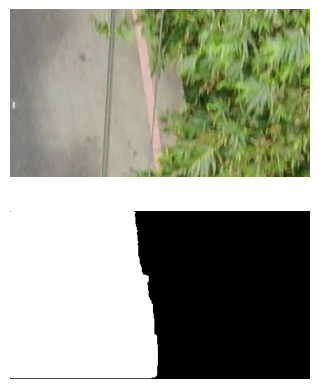

In [6]:
image_path_list = []
for image_path in glob.glob("./Dataset/Public_inference/*"):
    image_path_list.append(os.path.basename(image_path)[:-4])

image_name = image_path_list[random.randint(0, len(image_path_list))]
show_image(image_name)